<a href="https://colab.research.google.com/github/sanjeevroy08/ML-Project-Ransomware-Detection-/blob/main/mlproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os

def extract_zip(zip_path, extract_to="dataset"):
    """Extracts a ZIP file to a specified folder."""
    if not os.path.exists(extract_to):  # Create folder if not exists
        os.makedirs(extract_to)

    # Make sure zip_path is an absolute path if it is not already.
    if not os.path.isabs(zip_path):
        zip_path = os.path.abspath(zip_path)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    print(f"✅ Dataset extracted to '{extract_to}'")

# ==== RUN EXTRACTION ====
zip_filename = "ransomware.zip"  # Replace with your ZIP file
extract_folder = "ransomeware"  # Folder where data will be extracted

extract_zip(zip_filename, extract_folder)

1. Train Model
2. Detect Ransomware
Choose: 1
Reduced to 13 principal components

Model Evaluation Metrics

Accuracy: 0.9625

Precision: 0.9850
Recall:    0.9277
F1 Score:  0.9555

Classification Report:
              precision    recall  f1-score   support

        Safe       0.95      0.99      0.97     10610
  Ransomware       0.98      0.93      0.96      8136

    accuracy                           0.96     18746
   macro avg       0.97      0.96      0.96     18746
weighted avg       0.96      0.96      0.96     18746


Confusion Matrix:
[[10495   115]
 [  588  7548]]


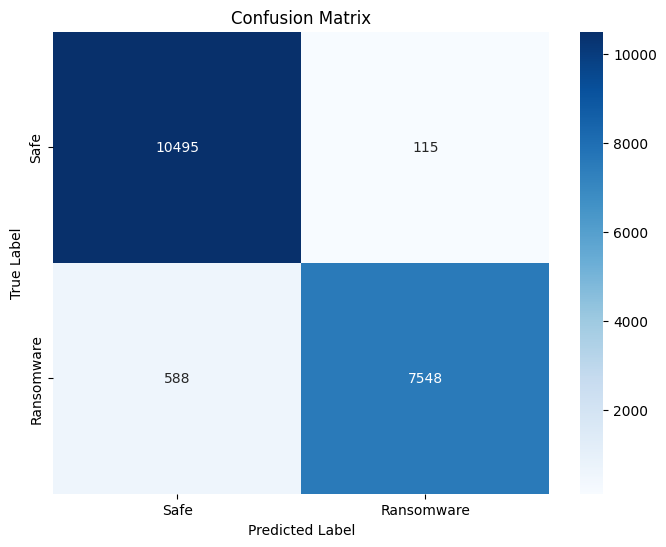


Cross-Validation Results

CV Accuracy: 0.9633 ± 0.0022


In [ ]:
import pandas as pd
import joblib
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, classification_report, confusion_matrix)
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

class RansomwareDetector:
    def __init__(self):
        self.scaler = None
        self.selector = None
        self.pca = None
        self.model = None
        self.expected_features = None
        self.feature_columns = None  # To track expected columns

    def load_and_preprocess_data(self, file_path, is_training=True):
        """Load and preprocess data with consistent feature processing"""
        df = pd.read_csv(file_path).dropna()


        cols_to_drop = ['FileName', 'md5Hash', 'BitcoinAddresses']
        df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

        # Store feature columns during training
        if is_training:
            self.feature_columns = df.columns[:-1]  # Exclude target

        # Ensure we have the same columns as training data
        if not is_training and hasattr(self, 'feature_columns'):
            missing_cols = set(self.feature_columns) - set(df.columns)
            if missing_cols:
                raise ValueError(f"Missing required columns: {missing_cols}")
            df = df[list(self.feature_columns) + [df.columns[-1]]]  # Reorder columns

        # Convert categorical columns
        categorical_cols = df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if len(df[col].unique()) > 50:
                freq = df[col].value_counts(normalize=True)
                df[col] = df[col].map(freq)
            else:
                df[col] = df[col].astype('category').cat.codes

        if is_training:
            y = df.iloc[:, -1]
            X = df.iloc[:, :-1]

            # Fit transformers on training data
            self.selector = VarianceThreshold(threshold=0.01)
            X = self.selector.fit_transform(X)
            self.scaler = StandardScaler()
            X = self.scaler.fit_transform(X)
            self.pca = PCA(n_components=0.95)
            X = self.pca.fit_transform(X)

            self.expected_features = X.shape[1]
            print(f"Reduced to {self.expected_features} principal components")
            return X, y
        else:
            # For detection, use already fitted transformers
            if not all([self.scaler, self.selector, self.pca]):
                raise ValueError("Please train the model first")

            X = df.iloc[:, :-1]  # Exclude target column
            X = self.selector.transform(X)
            X = self.scaler.transform(X)
            X = self.pca.transform(X)
            return X, None

    def evaluate_model(self, y_true, y_pred, classes=None):
        """Generate comprehensive evaluation metrics"""
        print("\n" + "="*50)
        print("Model Evaluation Metrics")
        print("="*50)

        print(f"\nAccuracy: {accuracy_score(y_true, y_pred):.4f}")
        print(f"\nPrecision: {precision_score(y_true, y_pred):.4f}")
        print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
        print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")

        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=classes))

        cm = confusion_matrix(y_true, y_pred)
        print("\nConfusion Matrix:")
        print(cm)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes, yticklabels=classes)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    def train_model(self):
        """Train model with comprehensive evaluation"""
        dataset_path = "/content/ransomeware/data_file.csv"
        X, y = self.load_and_preprocess_data(dataset_path)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y)

        class_names = ['Safe', 'Ransomware']

        self.model = RandomForestClassifier(
            n_estimators=100,
            max_depth=5,
            min_samples_split=10,
            random_state=42
        ).fit(X_train, y_train)

        y_pred = self.model.predict(X_test)
        self.evaluate_model(y_test, y_pred, class_names)

        print("\n" + "="*50)
        print("Cross-Validation Results")
        print("="*50)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(self.model, X, y, cv=cv, scoring='accuracy')
        print(f"\nCV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

        joblib.dump(self, "ransomware_detector.pkl")

    def detect_ransomware(self, file_path):
        try:
            X, _ = self.load_and_preprocess_data(file_path, is_training=False)

            if X.shape[1] != self.expected_features:
                raise ValueError(f"Expected {self.expected_features} features but got {X.shape[1]}")

            pred = self.model.predict(X)
            proba = self.model.predict_proba(X)

            print("\nDetection Results:")
            print(f"Class probabilities: {proba[0]}")
            print("Ransomware Detected!" if pred[0] == 1 else "File is Safe.")
            print(f"Confidence: {max(proba[0]):.2%}")

        except Exception as e:
            print(f"Detection error: {str(e)}")

if __name__ == "__main__":
    choice = input("1. Train Model\n2. Detect Ransomware\nChoose: ")

    if choice == "1":
        detector = RansomwareDetector()
        detector.train_model()
    else:
        try:
            detector = joblib.load("ransomware_detector.pkl")
            detector.detect_ransomware(input("Enter file path: "))
        except FileNotFoundError:
            print("Model not found. Please train the model first.")

1. Train Model (SVM)
2. Detect Ransomware
Choose: 1
Reduced to 13 principal components

Evaluation Metrics
Accuracy:  0.9670
Precision: 0.9705
Recall:    0.9530
F1 Score:  0.9617

Classification Report:
              precision    recall  f1-score   support

  Ransomware       0.96      0.98      0.97     10610
        Safe       0.97      0.95      0.96      8136

    accuracy                           0.97     18746
   macro avg       0.97      0.97      0.97     18746
weighted avg       0.97      0.97      0.97     18746



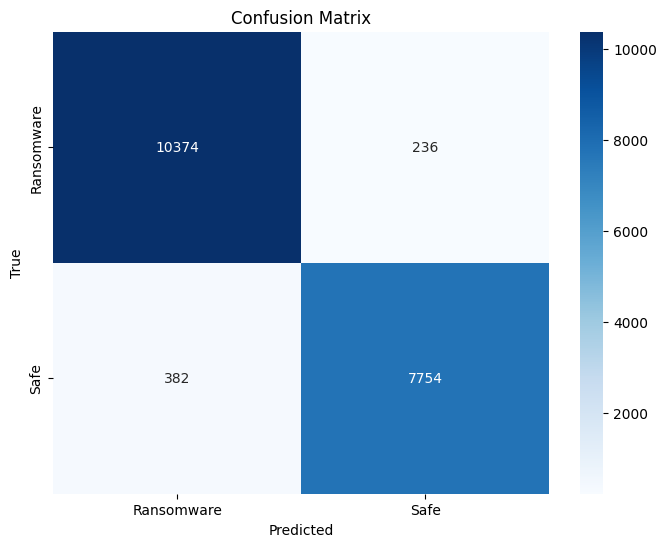

✅ Model saved as ransomware_detector_svm.pkl


In [36]:
import pandas as pd
import joblib
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os


class RansomwareDetectorSVM:
    def __init__(self):
        self.scaler = None
        self.selector = None
        self.pca = None
        self.model = None
        self.expected_features = None

    def load_and_preprocess_data(self, file_path, is_training=True):
        df = pd.read_csv(file_path).dropna()

        # Drop unnecessary columns
        cols_to_drop = ['FileName', 'md5Hash', 'BitcoinAddresses']
        df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

        # Separate label
        if 'Benign' not in df.columns:
            raise ValueError("Label column 'Benign' not found in dataset.")

        y = df['Benign']
        X = df.drop(columns=['Benign'])

        # Encode categorical columns
        categorical_cols = X.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if len(X[col].unique()) > 50:
                freq = X[col].value_counts(normalize=True)
                X[col] = X[col].map(freq)
            else:
                X[col] = X[col].astype('category').cat.codes

        if is_training:
            # Feature selection
            self.selector = VarianceThreshold(0.01)
            X = self.selector.fit_transform(X)

            # Scaling
            self.scaler = StandardScaler()
            X = self.scaler.fit_transform(X)

            # PCA
            self.pca = PCA(n_components=0.95, random_state=42)
            X = self.pca.fit_transform(X)

            self.expected_features = X.shape[1]
            print(f"Reduced to {self.expected_features} principal components")
            return X, y
        else:
            X = self.selector.transform(X)
            X = self.scaler.transform(X)
            X = self.pca.transform(X)
            return X, None

    def evaluate_model(self, y_true, y_pred):
        print("\n" + "=" * 50)
        print("Evaluation Metrics")
        print("=" * 50)
        print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
        print(f"Precision: {precision_score(y_true, y_pred):.4f}")
        print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
        print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=["Ransomware", "Safe"]))

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Ransomware", "Safe"], yticklabels=["Ransomware", "Safe"])
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

    def train_model(self):
        dataset_path = "/content/ransomeware/data_file.csv"
        if not os.path.exists(dataset_path):
            print(f"Training file not found at: {dataset_path}")
            return

        X, y = self.load_and_preprocess_data(dataset_path)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

        self.model = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
        self.model.fit(X_train, y_train)

        y_pred = self.model.predict(X_test)
        self.evaluate_model(y_test, y_pred)

        joblib.dump(self, "ransomware_detector_svm.pkl")
        print("✅ Model saved as ransomware_detector_svm.pkl")

    def detect_ransomware(self, file_path):
        try:
            X, _ = self.load_and_preprocess_data(file_path, is_training=False)

            if X.shape[1] != self.expected_features:
                raise ValueError(f"Expected {self.expected_features} features, got {X.shape[1]}")

            pred = self.model.predict(X)
            proba = self.model.predict_proba(X)

            print("\n🧪 Detection Results:")
            print(f"Class probabilities: {proba[0]}")
            print("🔐 Ransomware Detected!" if pred[0] == 0 else "✅ File is Safe.")
            print(f"Confidence: {max(proba[0]):.2%}")

        except Exception as e:
            print(f"❌ Detection error: {e}")


if __name__ == "__main__":
    choice = input("1. Train Model (SVM)\n2. Detect Ransomware\nChoose: ")

    if choice == "1":
        detector = RansomwareDetectorSVM()
        detector.train_model()
    elif choice == "2":
        try:
            detector = joblib.load("ransomware_detector_svm.pkl")
            path = input("Enter file path: ")
            detector.detect_ransomware(path)
        except FileNotFoundError:
            print("❌ Model not found. Please train the model first.")
    else:
        print("Invalid option selected.")


Reduced to 13 principal components
Reduced to 13 principal components


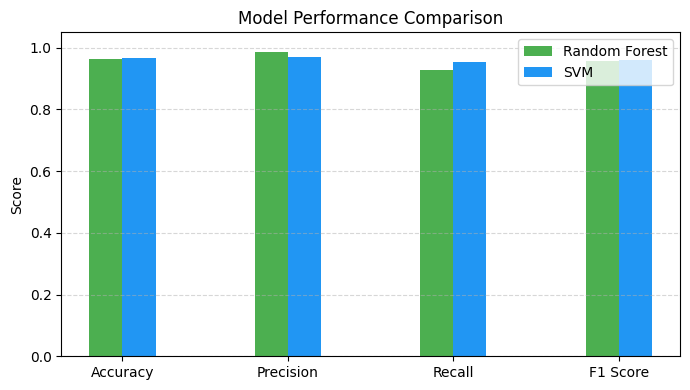

In [37]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# === Load Trained Models ===
rf_model = joblib.load("/content/ransomware_detector.pkl")
svm_model = joblib.load("/content/ransomware_detector_svm.pkl")

# === Load Dataset ===
dataset_path = "/content/ransomeware/data_file.csv"
X_rf, y_rf = rf_model.load_and_preprocess_data(dataset_path, is_training=True)
X_svm, y_svm = svm_model.load_and_preprocess_data(dataset_path, is_training=True)

# === Train-Test Split ===
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.3, random_state=42, stratify=y_rf)
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, test_size=0.3, random_state=42, stratify=y_svm)

# === Predictions ===
y_pred_rf = rf_model.model.predict(X_test_rf)
y_pred_svm = svm_model.model.predict(X_test_svm)

# === Evaluation Metrics ===
metrics = {
    'Accuracy': [
        accuracy_score(y_test_rf, y_pred_rf),
        accuracy_score(y_test_svm, y_pred_svm)
    ],
    'Precision': [
        precision_score(y_test_rf, y_pred_rf),
        precision_score(y_test_svm, y_pred_svm)
    ],
    'Recall': [
        recall_score(y_test_rf, y_pred_rf),
        recall_score(y_test_svm, y_pred_svm)
    ],
    'F1 Score': [
        f1_score(y_test_rf, y_pred_rf),
        f1_score(y_test_svm, y_pred_svm)
    ]
}

models = ['Random Forest', 'SVM']
metrics_df = pd.DataFrame(metrics, index=models)

# === Bar Plot (Compact) ===
bar_width = 0.2
x = np.arange(len(metrics_df.columns))  # [0, 1, 2, 3]

plt.figure(figsize=(7, 4))  # Smaller, cleaner figure
plt.bar(x - bar_width/2, metrics_df.iloc[0], width=bar_width, label='Random Forest', color='#4caf50')
plt.bar(x + bar_width/2, metrics_df.iloc[1], width=bar_width, label='SVM', color='#2196f3')

plt.xticks(ticks=x, labels=metrics_df.columns)
plt.ylim(0, 1.05)
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
